In [54]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import xgboost as xgb
import csv as csv
from xgboost import plot_importance
from matplotlib import pyplot
from sklearn.model_selection import cross_val_score,KFold
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV   #Performing grid search
from scipy.stats import skew
from collections import OrderedDict
from sklearn.inspection import permutation_importance
import shap
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold, KFold
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
import joblib
import numbers
import torch
from torch_geometric.loader import DataLoader  

In [55]:
# Fix random seed
def set_seed(seed):
    import random
    random.seed(seed)  # Fix Python's random seed
    np.random.seed(seed)  # Fix NumPy's random seed
    torch.manual_seed(seed)  # Fix PyTorch's random seed
    torch.cuda.manual_seed(seed)  # Fix random seed on GPU
    torch.backends.cudnn.deterministic = True  # Ensure CuDNN determinism
    torch.backends.cudnn.benchmark = False  # Disable non-deterministic algorithm optimization

# Call at the beginning of the function
set_seed(42)  # 42 is the seed value, can be replaced with other values

In [56]:
plt.style.use("style.mplstyle")

In [104]:
def save_model_with_joblib(model, filename):
    joblib.dump(model, filename)

In [ ]:
import torch
# Load dataset
def load_data_list(file_path):
    """
    Load a data list from a specified file path.

    Parameters:
    file_path (str): Path to the data list file.

    Returns:
    list: Loaded data list.
    """
    return torch.load(file_path)

############## Anion ##############
anion_load_file_path = 'dataset/anion_data_list.pt' # Complete dataset
anion_load_train_dataset_path = 'dataset/train_anion_data_list.pt' # Training set
anion_load_val_dataset_path = 'dataset/val_anion_data_list.pt' # Validation set
#anion_load_test_dataset_path = 'dataset/test_anion_data_list.pt' # Test set

# Load datasets
anion_loaded_data_list = load_data_list(anion_load_file_path)
anion_loaded_train_data_list = load_data_list(anion_load_train_dataset_path)
anion_loaded_val_data_list = load_data_list(anion_load_val_dataset_path)
#anion_loaded_test_data_list = load_data_list(anion_load_test_dataset_path)

# Print information about loaded datasets
print(f"Size of the loaded data list: {len(anion_loaded_data_list)}")
print(f"Size of the loaded training data list: {len(anion_loaded_train_data_list)}")
print(f"Size of the loaded validation data list: {len(anion_loaded_val_data_list)}")
#print(f"Size of the loaded test data list: {len(anion_loaded_test_data_list)}")

# Load training, validation, and test datasets
anion_train_loader = DataLoader(anion_loaded_train_data_list, batch_size=128, shuffle=True)  
anion_val_loader = DataLoader(anion_loaded_val_data_list, batch_size=128, shuffle=False)  
#anion_test_loader = DataLoader(anion_loaded_test_data_list, batch_size=128, shuffle=False)  


############## Cation ##############
cation_load_file_path = 'dataset/cation_data_list.pt' # Complete dataset
cation_load_train_dataset_path = 'dataset/train_cation_data_list.pt' # Training set
cation_load_val_dataset_path = 'dataset/val_cation_data_list.pt' # Validation set
#cation_load_test_dataset_path = 'dataset/test_cation_data_list.pt' # Test set

# Load datasets
cation_loaded_data_list = load_data_list(cation_load_file_path)
cation_loaded_train_data_list = load_data_list(cation_load_train_dataset_path)
cation_loaded_val_data_list = load_data_list(cation_load_val_dataset_path)
#cation_loaded_test_data_list = load_data_list(cation_load_test_dataset_path)

# Print information about loaded datasets
print(f"Size of the loaded data list: {len(cation_loaded_data_list)}")
print(f"Size of the loaded training data list: {len(cation_loaded_train_data_list)}")
print(f"Size of the loaded validation data list: {len(cation_loaded_val_data_list)}")
#print(f"Size of the loaded test data list: {len(cation_loaded_test_data_list)}")

# Load training, validation, and test datasets
cation_train_loader = DataLoader(cation_loaded_train_data_list, batch_size=128, shuffle=True)  
cation_val_loader = DataLoader(cation_loaded_val_data_list, batch_size=128, shuffle=False)  
#cation_test_loader = DataLoader(cation_loaded_test_data_list, batch_size=128, shuffle=False)  

In [151]:
cation_loaded_data_list[0]

Data(x=[52, 5], edge_index=[2, 102], y=[1, 17], idx=[1], name='c-c19+c-b37+c-b39+c-b81', smiles='[H]OC([H])(C([H])([H])[H])C([H])([H])C([H])([H])[P+](C([H])([H])C([H])([H])OC([H])([H])[H])(C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H]', morgan_fp=[1, 2048], moldescriptor=[1, 183])

In [165]:
import xgboost as xgb
import optuna
import time
import torch
import numpy as np
from sklearn.metrics import mean_squared_error

def extract_features_targets(data_list, target_index, feature="2Ddescriptors"):
    """
    Extract moldescriptor as features X and the specified index in y as target Y from the data list.
    
    Args:
        data_list (list): List containing Data objects.
        target_index (int): Index position in y to be predicted.
        feature (str): Optional "2Ddescriptors" or "fp", representing the features used for training the model.
        
    Returns:
        X (np.ndarray): Feature matrix.
        Y (np.ndarray): Target vector.
    """
    X = []
    Y = []
    for data in data_list:
        # Extract moldescriptor, assuming its shape is [1, 183]
        if feature == "2Ddescriptors":
            moldescriptor = data.moldescriptor.numpy().flatten()  # Use molecular descriptors as features
            X.append(moldescriptor)
            
        elif feature == "fp":
            fp = data.morgan_fp.numpy().flatten()  # Use molecular fingerprints as features
            X.append(fp)
            
        # Extract the specified index in y, assuming y's shape is [1, 17]
        target = data.y.numpy().flatten()[target_index] * 27.2  # Convert Hartree units to eV
        Y.append(target)
        
    X = np.array(X)
    Y = np.array(Y)
    return X, Y

def XGBoost_model_optuna(train_list, val_list, target_index=0, feature="2Ddescriptors"):
    """
    Use Optuna to optimize XGBoost model parameters, train, and evaluate the model.
    
    Args:
        train_list (list): Training set list (including all cation and anion data).
        val_list (list): Validation set list (including all cation and anion data).
        target_index (int): Index position in y to be predicted.
        feature (str): Optional "2Ddescriptors" or "fp", representing the features used for training the model.

    Returns:
        best_model (xgb.XGBRegressor): Trained XGBoost model.
    """
    start_time = time.time()
    
    # Extract training set features and targets
    X_train, y_train = extract_features_targets(train_list, target_index, feature)
    
    # Extract validation set features and targets
    X_val, y_val = extract_features_targets(val_list, target_index, feature)
    
    def objective(trial):
        # Define the search space
        param = {
            "max_depth": trial.suggest_int("max_depth", 3, 10),  # Maximum depth of the decision tree
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),  # Learning rate
            "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=50),  # Number of trees
            "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),  # Minimum sum of weights of child nodes
            "gamma": trial.suggest_float("gamma", 0, 5),  # Minimum loss reduction required to split
            "subsample": trial.suggest_float("subsample", 0.6, 1.0),  # Subsampling ratio of data
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),  # Subsampling ratio of features
            "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10, log=True),  # L1 regularization
            "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10, log=True),  # L2 regularization
        }
        
        # Initialize the model
        model = xgb.XGBRegressor(
            objective="reg:squarederror",
            **param,
            random_state=42,
            n_jobs=-1
        )
        
        # Train the model
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            early_stopping_rounds=30,
            verbose=False
        )
        
        # Validation set predictions
        y_pred = model.predict(X_val)
        
        # Return mean squared error
        return mean_squared_error(y_val, y_pred)
    
    # Use Optuna for parameter optimization
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=100, timeout=600)  # Run X trials, maximum optimization time 600 seconds
    
    # Get the best parameters
    best_params = study.best_params
    print("Best parameters: ", best_params)
    
    # Train the final model using the best parameters
    best_model = xgb.XGBRegressor(
        objective="reg:squarederror",
        **best_params,
        random_state=42,
        n_jobs=-1
    )
    best_model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        early_stopping_rounds=30,
        verbose=False
    )
    
    # Output training time
    end_time = time.time()
    print("Training time: {:.2f} seconds".format(end_time - start_time))
    
    # Evaluate the final model
    y_final_pred = best_model.predict(X_val)
    final_mse = mean_squared_error(y_val, y_final_pred)
    print("Final validation set mean squared error (MSE): {:.4f}".format(final_mse))
    
    return best_model

In [166]:
cation_loaded_train_data_list[0]

Data(x=[50, 5], edge_index=[2, 98], y=[1, 17], idx=[1], name='c-c19+c-b10+c-b18+c-b79', smiles='[H]OC([H])([H])C([H])([H])C([H])([H])C([H])([H])[P+](C([H])([H])C(=O)C([H])([H])C([H])([H])[H])(C([H])([H])C([H])([H])C([H])([H])[H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H]', morgan_fp=[1, 2048], moldescriptor=[1, 183])

In [175]:
anion_xgb_model_fp = XGBoost_model_optuna(
    train_list=anion_loaded_train_data_list,
    val_list=anion_loaded_val_data_list,
    target_index=11, feature = "fp")

[I 2024-12-20 17:22:46,175] A new study created in memory with name: no-name-0a7ec687-0175-422d-ad2f-9e82f51a24a5
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
[I 2024-12-20 17:22:46,784] Trial 0 finished with value: 0.11923504845769275 and parameters: {'max_depth': 7, 'learning_rate': 0.04838085341085586, 'n_estimators': 250, 'min_child_weight': 8, 'gamma': 4.986088753938091, 'subsample': 0.9797787369855347, 'colsample_bytree': 0.7472088421034524, 'reg_alpha': 0.0016111074308009625, 'reg_lambda': 6.973001678901891}. Best is trial 0 with value: 0.11923504845769275.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
[W 2024-12-20 17:22:47,664] Trial 1 failed with parameters: {'max_depth': 9, 'learning_rate': 0.013753521832857473, 'n_estimators': 400, 'min_ch

KeyboardInterrupt: 

MSE (Mean Squared Error): 0.04
MAE (Mean Absolute Error): 0.13
RMSE (Root Mean Squared Error): 0.20
R^2 Score: 0.97


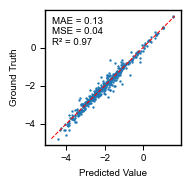

In [181]:
evaluate_model(anion_xgb_model_fp, anion_loaded_val_data_list, target_index=11, figname="model_evaluation",
                   figsize=(1.75, 1.75), output=False, feature = "fp")

In [ ]:
anion_xgb_model = XGBoost_model_optuna(
    train_list=anion_loaded_train_data_list,
    val_list=anion_loaded_val_data_list,
    target_index=11)

In [72]:
anion_xgb_model = XGBoost_model_optuna(
    train_list=anion_loaded_train_data_list,
    val_list=anion_loaded_val_data_list,
    target_index=11)

[I 2024-12-19 18:20:05,865] A new study created in memory with name: no-name-b167eed0-1a13-41e7-b8ac-9be0db172c15
[I 2024-12-19 18:20:06,089] Trial 0 finished with value: 0.10313805006078798 and parameters: {'max_depth': 10, 'learning_rate': 0.09014724070840613, 'n_estimators': 550, 'min_child_weight': 1, 'gamma': 1.9721321046017808, 'subsample': 0.6585025760825395, 'colsample_bytree': 0.8821826231842846, 'reg_alpha': 1.4033465275903011e-08, 'reg_lambda': 0.17102009883278546}. Best is trial 0 with value: 0.10313805006078798.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
[I 2024-12-19 18:20:06,261] Trial 1 finished with value: 0.13623648605589406 and parameters: {'max_depth': 10, 'learning_rate': 0.1437468534803948, 'n_estimators': 500, 'min_child_weight': 6, 'gamma': 4.517808013168005, 'subsample': 0.7153593167678685, 'colsample_bytree': 0.9564104122568429, 'reg_alpha'

最佳参数:  {'max_depth': 5, 'learning_rate': 0.1765689619974955, 'n_estimators': 700, 'min_child_weight': 2, 'gamma': 0.010204986036140753, 'subsample': 0.8552510534463111, 'colsample_bytree': 0.9437236305850785, 'reg_alpha': 0.01578733744383972, 'reg_lambda': 0.3740720034615035}
训练时间: 34.79 秒
最终验证集均方误差 (MSE): 0.0514


In [73]:
cation_xgb_model = XGBoost_model_optuna(
    train_list=cation_loaded_train_data_list,
    val_list=cation_loaded_val_data_list,
    target_index=12)

[I 2024-12-19 18:20:40,678] A new study created in memory with name: no-name-b563d3c2-0780-4d86-9648-993ce0d9facc
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
[I 2024-12-19 18:20:40,815] Trial 0 finished with value: 0.09218500375559276 and parameters: {'max_depth': 4, 'learning_rate': 0.10735760845768387, 'n_estimators': 200, 'min_child_weight': 3, 'gamma': 2.33855439411541, 'subsample': 0.7454262625845263, 'colsample_bytree': 0.7443091136402912, 'reg_alpha': 7.643095555691444e-07, 'reg_lambda': 0.014935015108894188}. Best is trial 0 with value: 0.09218500375559276.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
[I 2024-12-19 18:20:40,957] Trial 1 finished with value: 0.09310265878165376 and parameters: {'max_depth': 3, 'learning_rate': 0.0535728684805

最佳参数:  {'max_depth': 9, 'learning_rate': 0.010784825033909104, 'n_estimators': 600, 'min_child_weight': 7, 'gamma': 0.006171432314628381, 'subsample': 0.6003701080881989, 'colsample_bytree': 0.7978309740254306, 'reg_alpha': 0.06780366140412988, 'reg_lambda': 3.082749463996724e-08}
训练时间: 66.55 秒
最终验证集均方误差 (MSE): 0.0688


In [179]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def evaluate_model(model, val_list, target_index=0, figname="model_evaluation",
                   figsize=(1.75, 1.75), output=False, feature="2Ddescriptors"):
    """
    Evaluate the model on the validation set and print various performance metrics.
    
    Parameters:
        model -- Trained machine learning model
        val_list -- Validation set list (containing all data)
        target_index (int) -- Index position in y to be predicted, default is 0
        figname (str) -- File name to save the plot, excluding the extension, default is "model_evaluation"
        figsize (tuple) -- Size of the plot, default is (6, 6)
        output (bool) -- Whether to save the plot, default is False
    
    Returns:
        None
    """
    
    # Extract features and targets from the validation set
    X_test, y_test = extract_features_targets(val_list, target_index, feature)
    
    # Set font to Arial
    plt.rcParams["font.family"] = "Arial"
    
    # Use the model to predict on the test set
    y_pred = model.predict(X_test)
    
    # Calculate MSE
    mse = mean_squared_error(y_test, y_pred)
    print(f"MSE (Mean Squared Error): {mse:.2f}")
    
    # Calculate MAE
    mae = mean_absolute_error(y_test, y_pred)
    print(f"MAE (Mean Absolute Error): {mae:.2f}")
    
    # Calculate RMSE
    rmse = np.sqrt(mse)  # RMSE is the square root of MSE
    print(f"RMSE (Root Mean Squared Error): {rmse:.2f}")
    
    # Calculate R^2 Score
    r2 = r2_score(y_test, y_pred)
    print(f"R^2 Score: {r2:.2f}")
   
    # Visualize predicted vs. true values
    f, ax = plt.subplots(figsize=figsize)  # Create figure and axis objects
    ax.scatter(y_pred, y_test, s=0.5)  # Plot scatter points with adjusted size and transparency
    
    # Plot reference line with slope of 1
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], color="red", linestyle="--")  # Add reference line
    
    plt.xlabel("Predicted Value")  # Set X-axis label
    plt.ylabel("Ground Truth")     # Set Y-axis label
    # plt.title("Predicted vs Ground Truth")  # Set plot title
    
    # Display MAE, MSE, and R² in the top left corner
    text_str = f"MAE = {mae:.2f}\nMSE = {mse:.2f}\nR² = {r2:.2f}"
    plt.text(
        0.05, 0.95, text_str,
        transform=ax.transAxes,  # Use axis coordinates for positioning
        fontsize=7, color="black",
        verticalalignment="top", horizontalalignment="left",
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='none')
    )
    
    # Set border width
    for spine in ax.spines.values():
        spine.set_linewidth(1)
    
    # Save the plot (if output is True)
    if output:
        plt.savefig(f"{figname}.png", dpi=300, bbox_inches="tight")
    
    plt.show()

In [182]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def evaluate_model_cation_anion(anion_model, cation_model, anion_val_list, cation_val_list, target_index_anion=0, target_index_cation=0,
                                figname="model_evaluation", figsize=(1.75, 1.75), output=False, feature="2Ddescriptors"):
    """
    Evaluate both anion and cation models on their respective validation sets and plot scatter diagrams of predicted vs. true values.
    
    Parameters:
        anion_model -- Trained machine learning model for anions
        cation_model -- Trained machine learning model for cations
        anion_val_list -- Validation set list for anions (containing all anion data)
        cation_val_list -- Validation set list for cations (containing all cation data)
        target_index (int) -- Index position in y to be predicted, default is 0
        figname (str) -- File name to save the plot, excluding the extension, default is "model_evaluation"
        figsize (tuple) -- Size of the plot, default is (3.5, 3.5)
        output (bool) -- Whether to save the plot, default is False
    
    Returns:
        None
    """
    
    # Extract features and targets for the anion validation set
    X_anion, y_anion = extract_features_targets(anion_val_list, target_index_anion, feature)
    
    # Extract features and targets for the cation validation set
    X_cation, y_cation = extract_features_targets(cation_val_list, target_index_cation, feature)
    
    print(len(X_cation[0]))
    
    # Set font to Arial
    plt.rcParams["font.family"] = "Arial"
    
    # Use the model to predict on the anion validation set
    y_anion_pred = anion_model.predict(X_anion)
    
    # Use the model to predict on the cation validation set
    y_cation_pred = cation_model.predict(X_cation)
    
    # Calculate performance metrics for anions
    mse_anion = mean_squared_error(y_anion, y_anion_pred)
    mae_anion = mean_absolute_error(y_anion, y_anion_pred)
    rmse_anion = np.sqrt(mse_anion)
    r2_anion = r2_score(y_anion, y_anion_pred)
    
    # Calculate performance metrics for cations
    mse_cation = mean_squared_error(y_cation, y_cation_pred)
    mae_cation = mean_absolute_error(y_cation, y_cation_pred)
    rmse_cation = np.sqrt(mse_cation)
    r2_cation = r2_score(y_cation, y_cation_pred)
    
    # Print performance metrics
    print("Performance metrics for the anion model:")
    print(f"MSE: {mse_anion:.2f}")
    print(f"MAE: {mae_anion:.2f}")
    print(f"RMSE: {rmse_anion:.2f}")
    print(f"R²: {r2_anion:.2f}\n")
    
    print("Performance metrics for the cation model:")
    print(f"MSE: {mse_cation:.2f}")
    print(f"MAE: {mae_cation:.2f}")
    print(f"RMSE: {rmse_cation:.2f}")
    print(f"R²: {r2_cation:.2f}\n")
    
    # Create figure and axis objects
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot scatter diagram for anions (blue)
    scatter_anion = ax.scatter(y_anion_pred, y_anion, s=0.5, color='#bfcfe4', label='Anion')
    
    # Plot scatter diagram for cations (red)
    scatter_cation = ax.scatter(y_cation_pred, y_cation, s=0.5, color='#f7c0c5', label='Cation')
    
    # Plot reference line y = x
    min_val = min(np.min(y_anion), np.min(y_cation), np.min(y_anion_pred), np.min(y_cation_pred))
    max_val = max(np.max(y_anion), np.max(y_cation), np.max(y_anion_pred), np.max(y_cation_pred))
    ax.plot([min_val, max_val], [min_val, max_val], color="gray", linestyle="--")
    
    # Set axis labels
    plt.xlabel("Predicted Value")
    plt.ylabel("Ground Truth")

    plt.title("XGBoost")
    
    # Display labels in the legend
    ax.legend(loc='lower right')
    
    # Set border width
    for spine in ax.spines.values():
        spine.set_linewidth(1)
    
    # Save the plot (if output is True)
    if output:
        plt.savefig(f"{figname}.png", dpi=300, bbox_inches="tight")
    
    plt.show()

In [ ]:
evaluate_model_cation_anion(anion_xgb_model, cation_xgb_model, anion_loaded_val_data_list, cation_loaded_val_data_list,
               target_index_anion=11,target_index_cation=12,
               figname="XGBoost_cation_anion_val", figsize=(1.75, 1.75), output=True)

MSE (Mean Squared Error): 0.05
MAE (Mean Absolute Error): 0.15
RMSE (Root Mean Squared Error): 0.23
R^2 Score: 0.96


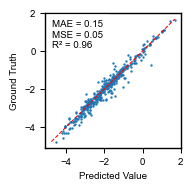

In [118]:
evaluate_model(anion_xgb_model, anion_loaded_val_data_list, target_index=11,
               figname="anion_XGBoost_val_LUMO", figsize=(1.75, 1.75), output=True)

MSE (Mean Squared Error): 0.07
MAE (Mean Absolute Error): 0.13
RMSE (Root Mean Squared Error): 0.26
R^2 Score: 0.96


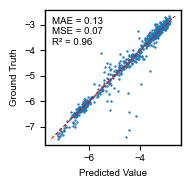

In [119]:
evaluate_model(cation_xgb_model, cation_loaded_val_data_list, target_index=12,
               figname="cation_XGBoost_val_HOMO", figsize=(1.75, 1.75), output=True)

In [106]:
save_model_with_joblib(anion_xgb_model, 'model/anion_xgb_model.joblib')
save_model_with_joblib(cation_xgb_model, 'model/cation_xgb_model.joblib')

In [82]:
anion_25_load_train_dataset_path = 'dataset/train_anion_data_list_25.pt' 
anion_25_loaded_train_data_list = load_data_list(anion_25_load_train_dataset_path)
cation_25_load_train_dataset_path = 'dataset/train_cation_data_list_25.pt'
cation_25_loaded_train_data_list = load_data_list(cation_25_load_train_dataset_path)

anion_50_load_train_dataset_path = 'dataset/train_anion_data_list_50.pt'
anion_50_loaded_train_data_list = load_data_list(anion_50_load_train_dataset_path)
cation_50_load_train_dataset_path = 'dataset/train_cation_data_list_50.pt' 
cation_50_loaded_train_data_list = load_data_list(cation_50_load_train_dataset_path) 

anion_75_load_train_dataset_path = 'dataset/train_anion_data_list_75.pt'
anion_75_loaded_train_data_list = load_data_list(anion_75_load_train_dataset_path)
cation_75_load_train_dataset_path = 'dataset/train_cation_data_list_75.pt'
cation_75_loaded_train_data_list = load_data_list(cation_75_load_train_dataset_path)

# 25%

In [83]:
anion_xgb_model_25 = XGBoost_model_optuna(
    train_list=anion_25_loaded_train_data_list,
    val_list=anion_loaded_val_data_list,
    target_index=11)

[I 2024-12-19 18:36:10,664] A new study created in memory with name: no-name-5b437f38-f064-4807-9c39-8ca535879ac2
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
[I 2024-12-19 18:36:10,984] Trial 0 finished with value: 0.17343966061676575 and parameters: {'max_depth': 8, 'learning_rate': 0.024344116771860352, 'n_estimators': 300, 'min_child_weight': 10, 'gamma': 1.856685354016709, 'subsample': 0.6023654410078572, 'colsample_bytree': 0.6827087084250508, 'reg_alpha': 1.0499204527596008e-08, 'reg_lambda': 8.91958806655829e-06}. Best is trial 0 with value: 0.17343966061676575.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
[I 2024-12-19 18:36:11,389] Trial 1 finished with value: 0.21230537428898869 and parameters: {'max_depth': 9, 'learning_rate': 0.027080449

最佳参数:  {'max_depth': 6, 'learning_rate': 0.01250511385673207, 'n_estimators': 700, 'min_child_weight': 1, 'gamma': 0.013393482685226998, 'subsample': 0.7252494832952452, 'colsample_bytree': 0.9361387243228321, 'reg_alpha': 0.0002954963930895558, 'reg_lambda': 4.808105051079057}
训练时间: 79.08 秒
最终验证集均方误差 (MSE): 0.1055


In [95]:
cation_xgb_model_25 = XGBoost_model_optuna(
    train_list=cation_25_loaded_train_data_list,
    val_list=cation_loaded_val_data_list,
    target_index=12)

[I 2024-12-19 18:43:24,217] A new study created in memory with name: no-name-9e7aaefc-678f-4426-abb7-27900dab79bb
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
[I 2024-12-19 18:43:24,343] Trial 0 finished with value: 0.13501364727470436 and parameters: {'max_depth': 6, 'learning_rate': 0.159476872192532, 'n_estimators': 100, 'min_child_weight': 3, 'gamma': 4.728043719956073, 'subsample': 0.6808536183086167, 'colsample_bytree': 0.874919967078309, 'reg_alpha': 1.5305050985492648e-07, 'reg_lambda': 2.5385647311857406e-06}. Best is trial 0 with value: 0.13501364727470436.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
[I 2024-12-19 18:43:24,402] Trial 1 finished with value: 0.13589050552693013 and parameters: {'max_depth': 6, 'learning_rate': 0.179284865520

最佳参数:  {'max_depth': 10, 'learning_rate': 0.011629990443077295, 'n_estimators': 700, 'min_child_weight': 8, 'gamma': 0.01027001239221316, 'subsample': 0.6290463319996749, 'colsample_bytree': 0.9986768754597454, 'reg_alpha': 3.1190238517515876e-05, 'reg_lambda': 1.1330987938036572e-08}
训练时间: 115.91 秒
最终验证集均方误差 (MSE): 0.0795


MSE (Mean Squared Error): 0.11
MAE (Mean Absolute Error): 0.23
RMSE (Root Mean Squared Error): 0.32
R^2 Score: 0.92


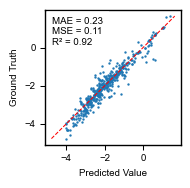

In [120]:
evaluate_model(anion_xgb_model_25, anion_loaded_val_data_list, target_index=11,
               figname="anion_XGBoost_val_25", figsize=(1.75, 1.75), output=True)

MSE (Mean Squared Error): 0.08
MAE (Mean Absolute Error): 0.16
RMSE (Root Mean Squared Error): 0.28
R^2 Score: 0.96


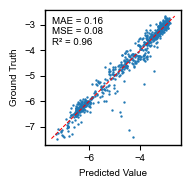

In [127]:
evaluate_model(cation_xgb_model_25, cation_loaded_val_data_list, target_index=12,
               figname="cation_XGBoost_val_25", figsize=(1.75, 1.75), output=True)

In [107]:
save_model_with_joblib(anion_xgb_model_25, 'model/anion_xgb_model_25.joblib')
save_model_with_joblib(cation_xgb_model_25, 'model/cation_xgb_model_25.joblib')

# 50%

In [ ]:
anion_xgb_model_50 = XGBoost_model_optuna(
    train_list=anion_50_loaded_train_data_list,
    val_list=anion_loaded_val_data_list,
    target_index=11)

In [88]:
cation_xgb_model_50 = XGBoost_model_optuna(
    train_list=cation_50_loaded_train_data_list,
    val_list=cation_loaded_val_data_list,
    target_index=12)

[I 2024-12-19 18:39:48,809] A new study created in memory with name: no-name-996bdccd-2a1c-4310-b25d-e46de3c49dfd
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
[I 2024-12-19 18:39:48,911] Trial 0 finished with value: 0.0999420613293356 and parameters: {'max_depth': 9, 'learning_rate': 0.09358394847782799, 'n_estimators': 950, 'min_child_weight': 2, 'gamma': 2.348580026075155, 'subsample': 0.6036122741591385, 'colsample_bytree': 0.6541674818991171, 'reg_alpha': 2.091772980400067e-07, 'reg_lambda': 4.5417017760966277e-07}. Best is trial 0 with value: 0.0999420613293356.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
[I 2024-12-19 18:39:49,096] Trial 1 finished with value: 0.08470774856613904 and parameters: {'max_depth': 8, 'learning_rate': 0.080890822139

最佳参数:  {'max_depth': 8, 'learning_rate': 0.02065403730064312, 'n_estimators': 950, 'min_child_weight': 10, 'gamma': 0.015393904063406495, 'subsample': 0.9246267190492021, 'colsample_bytree': 0.7233888265256773, 'reg_alpha': 0.08825472943336031, 'reg_lambda': 1.1956021218289558e-06}
训练时间: 48.35 秒
最终验证集均方误差 (MSE): 0.0769


MSE (Mean Squared Error): 0.08
MAE (Mean Absolute Error): 0.19
RMSE (Root Mean Squared Error): 0.28
R^2 Score: 0.94


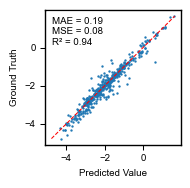

In [125]:
evaluate_model(anion_xgb_model_50, anion_loaded_val_data_list, target_index=11,
               figname="anion_XGBoost_val_50", figsize=(1.75, 1.75), output=True)

MSE (Mean Squared Error): 0.08
MAE (Mean Absolute Error): 0.14
RMSE (Root Mean Squared Error): 0.28
R^2 Score: 0.96


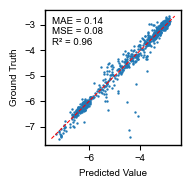

In [126]:
evaluate_model(cation_xgb_model_50, cation_loaded_val_data_list, target_index=12,
               figname="cation_XGBoost_val_50", figsize=(1.75, 1.75), output=True)

In [108]:
save_model_with_joblib(anion_xgb_model_50, 'model/anion_xgb_model_50.joblib')
save_model_with_joblib(cation_xgb_model_50, 'model/cation_xgb_model_50.joblib')

# 75%

In [100]:
anion_xgb_model_75 = XGBoost_model_optuna(
    train_list=anion_75_loaded_train_data_list,
    val_list=anion_loaded_val_data_list,
    target_index=11)

[I 2024-12-19 18:45:40,540] A new study created in memory with name: no-name-93658463-2a28-4942-ad1c-09e18ceb24c3
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
[I 2024-12-19 18:45:41,004] Trial 0 finished with value: 0.1392933325689856 and parameters: {'max_depth': 7, 'learning_rate': 0.014706268308547009, 'n_estimators': 800, 'min_child_weight': 5, 'gamma': 4.372068488812813, 'subsample': 0.8149940819893403, 'colsample_bytree': 0.7898499122788427, 'reg_alpha': 9.776958153371961e-07, 'reg_lambda': 0.3167409228233965}. Best is trial 0 with value: 0.1392933325689856.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
[I 2024-12-19 18:45:41,200] Trial 1 finished with value: 0.0944108019559794 and parameters: {'max_depth': 7, 'learning_rate': 0.0604821548622486

最佳参数:  {'max_depth': 6, 'learning_rate': 0.05741732858723043, 'n_estimators': 600, 'min_child_weight': 7, 'gamma': 0.0022013533111813408, 'subsample': 0.9034868485006095, 'colsample_bytree': 0.6747406990537012, 'reg_alpha': 0.00045309344063410934, 'reg_lambda': 1.4250032996477466}
训练时间: 34.21 秒
最终验证集均方误差 (MSE): 0.0630


In [105]:
cation_xgb_model_75 = XGBoost_model_optuna(
    train_list=cation_75_loaded_train_data_list,
    val_list=cation_loaded_val_data_list,
    target_index=12)

[I 2024-12-19 18:47:56,033] A new study created in memory with name: no-name-1f6a7984-da01-4337-94be-b12ef50433c0
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
[I 2024-12-19 18:47:56,305] Trial 0 finished with value: 0.10066953866936727 and parameters: {'max_depth': 3, 'learning_rate': 0.09408418673550899, 'n_estimators': 900, 'min_child_weight': 9, 'gamma': 4.492221472023107, 'subsample': 0.7024964347985989, 'colsample_bytree': 0.6816505183546563, 'reg_alpha': 1.5090299475685214e-08, 'reg_lambda': 2.2725057644678786e-07}. Best is trial 0 with value: 0.10066953866936727.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
[I 2024-12-19 18:47:56,481] Trial 1 finished with value: 0.09945875567851059 and parameters: {'max_depth': 3, 'learning_rate': 0.057923544

最佳参数:  {'max_depth': 10, 'learning_rate': 0.11822032937721509, 'n_estimators': 100, 'min_child_weight': 9, 'gamma': 0.00568016923543424, 'subsample': 0.8848931833842467, 'colsample_bytree': 0.919033464549771, 'reg_alpha': 0.00016857473785787205, 'reg_lambda': 0.10251606891358568}
训练时间: 51.39 秒
最终验证集均方误差 (MSE): 0.0686


MSE (Mean Squared Error): 0.06
MAE (Mean Absolute Error): 0.16
RMSE (Root Mean Squared Error): 0.25
R^2 Score: 0.95


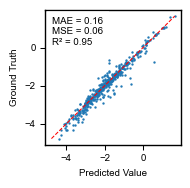

In [128]:
evaluate_model(anion_xgb_model_75, anion_loaded_val_data_list, target_index=11,
               figname="anion_XGBoost_val_75",figsize=(1.75, 1.75), output=True)

MSE (Mean Squared Error): 0.07
MAE (Mean Absolute Error): 0.14
RMSE (Root Mean Squared Error): 0.26
R^2 Score: 0.96


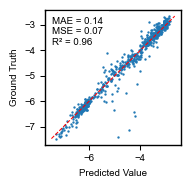

In [129]:
evaluate_model(cation_xgb_model_75, cation_loaded_val_data_list, target_index=12,
               figname="cation_XGBoost_val_75",figsize=(1.75, 1.75), output=True)

In [110]:
save_model_with_joblib(anion_xgb_model_75, 'model/anion_xgb_model_75.joblib')
save_model_with_joblib(cation_xgb_model_75, 'model/cation_xgb_model_75.joblib')